In [1]:
# data from https://github.com/nplcode/lfads-neural-stitching-reproduce
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
from scipy.ndimage import gaussian_filter1d

import scipy
from ssSVD import get_ssSVD

from matplotlib.cm import get_cmap
cmap = get_cmap('Dark2')
from matplotlib import animation 
from matplotlib.lines import Line2D
from IPython.display import HTML

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    ret = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return ret

In [3]:
# load data - first session
# file_loc = 'lfads-neural-stitching-reproduce/export_v05_broadbandRethreshNonSorted_filtered/subject_Pierre.date_2016-08-19.saveTagGroup_1.saveTag_2,3,5_export.mat'
file_loc = 'E:\\streamingSVD\\lfads-neural-stitching-reproduce\\export_v05_broadbandRethreshNonSorted_filtered\\subject_Pierre.date_2016-08-19.saveTagGroup_1.saveTag_2,3,5_export.mat'

# using loadmat like this, syntax equals matlab struct (struct.field)
mat_contents = sio.loadmat(file_loc, struct_as_record=False, squeeze_me=True)  
data = mat_contents['data']
# spikes = data.spikeRasters # 3d np array in (trial, longest_time, neuron)


In [4]:
# getting spikes aligned, concatenating all trials

align_to = 'GoCue' # 'Move' # 'GoCue' #
num_steps = 1000
num_trials = 100
bin_size = 15 # in ms

reduced_bins = int(num_steps / bin_size)
trial_types = []
    
reach_labels = dict(DownLeft=0, Left=1, UpLeft=2, Up=3, UpRight=4, Right=5, DownRight=6)

spikes = np.zeros((24, num_trials * reduced_bins))
t = 0
for i in range(num_trials):
    trial_types.append(data.targetDirectionName[i])
    
    if align_to == 'TargetOnset':
        start = data.TargetOnset[i]
    elif align_to == 'GoCue':
        start = data.GoCue[i]
    elif align_to == 'Move':
        start = data.Move[i] - 300
        
    end = start + num_steps
    curr_spikes = np.copy(data.spikeRasters[i, start:end, :].T)
    
    # reducing bin size
    spikes_reduced = np.zeros((data.nUnits, reduced_bins))
    for j in range(24):
        t1 = 0
        for k in range(spikes_reduced.shape[1]):
            spikes_reduced[j, k] = np.sum(curr_spikes[j, t1:t1+bin_size])
            t1 += bin_size
    
    # smoothing
#     for j in range(spikes_reduced.shape[0]):
#         spikes_reduced[j, :] = gaussian_filter1d(spikes_reduced[j, :], sigma=5)
    
    spikes[:, t:t+reduced_bins] = spikes_reduced
    t += reduced_bins
    

# smoothing spikes
spikes_smoothed = np.zeros(spikes.shape)
for i in range(spikes.shape[0]):
    spikes_smoothed[i, :] = gaussian_filter1d(spikes[i, :].astype('float'), sigma=2)
spikes = spikes_smoothed

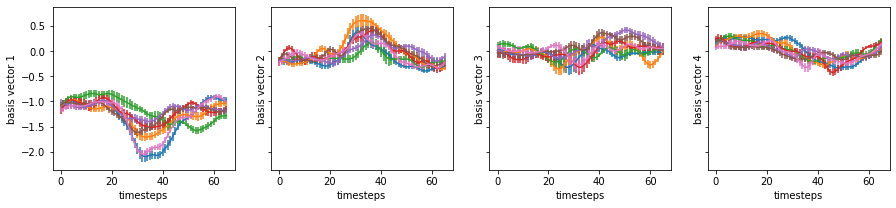

In [5]:
# projecting smoothed spikes onto subspace discovered by svd on whole dataset
u, s, v = np.linalg.svd(spikes, full_matrices=False)
proj = u.T.dot(spikes)

# plotting projected neural trajectories by component and trial type
reach_labels = dict(DownLeft=0, Left=1, UpLeft=2, Up=3, UpRight=4, Right=5, DownRight=6)
proj_by_trial = [[] for _ in range(len(reach_labels))]
t = 0
for i in range(num_trials):
    trial_type = reach_labels[trial_types[i]]
    curr_proj = proj[:, t:t+reduced_bins]
    proj_by_trial[trial_type].append(curr_proj)
    t += int(num_steps/bin_size)
    
# averaging over all trials of a certain type
mean_pcs = np.zeros((len(reach_labels), data.nUnits, reduced_bins))
std_pcs = np.zeros((len(reach_labels), data.nUnits, reduced_bins))
for i in range(len(reach_labels)):
    proj_by_trial[i] = np.array(proj_by_trial[i])
    mean_pcs[i, :, :] = np.mean(proj_by_trial[i], axis=0)
    std_pcs[i, :, :] = np.std(proj_by_trial[i], axis=0) / np.sqrt(proj_by_trial[i].shape[0])
    
    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i in range(4):
    for j in range(7):
        ax[i].errorbar(np.arange(reduced_bins), mean_pcs[j, i, :], yerr=std_pcs[j, i, :])
        ax[i].set(xlabel='timesteps', ylabel='basis vector {}'.format(i+1))

In [6]:
# doing streamingSVD on smoothed spikes, projecting spikes onto the learned subspace

l1 = 25  # num cols to init with
l = 1    # num cols processed per iter
decay = 1 # 'forgetting' to track nonstationarity. 1 = no forgetting
k = 24     # number of singular basis vectors to keep 
num_iters = np.ceil((spikes.shape[1] - l1) / l).astype('int') # num iters to go through once

# run streaming svd - returns Qcoll, shape (n, l1, num_iters)
Qtcoll, Scoll, Qcoll = get_ssSVD(spikes, k, l1, l, num_iters, decay_alpha=decay)

In [7]:
# projecting each timepoint of neural activity onto the subspace learned for that chunk
all_projs_stream = np.zeros((Qcoll.shape[1], Qtcoll.shape[2]*l))
for i in range(Qcoll.shape[2]):
    Q = Qcoll[:, :, i] # has first k components
#     Q = Q.dot(U)
    if i == 0:
        curr_neural = spikes[:, :l1]
        all_projs_stream[:, :l1] = (curr_neural.T.dot(Q)).T
        t = l1
    else: 
        # aligning neural to Q (depends on l1 and l)
        curr_neural = spikes[:, l1+((i-1)*l):l1+(i*l)]
        
        # projecting curr_neural onto curr_Q (our tracked subspace) and on full svd u
        all_projs_stream[:, t:t+l] = (curr_neural.T.dot(Q)).T
        t += l
        
all_projs_stream_true = np.zeros((Qtcoll.shape[1], Qtcoll.shape[2]*l))
for i in range(Qtcoll.shape[2]):
    Q = Qtcoll[:, :, i]
    if i == 0:
        curr_neural = spikes[:, :l1]
        all_projs_stream_true[:, :l1] = (curr_neural.T.dot(Q)).T
        t = l1
    else: 
        # aligning neural to Q (depends on l1 and l)
        curr_neural = spikes[:, l1+((i-1)*l):l1+(i*l)]
        
        # projecting curr_neural onto curr_Q (our tracked subspace) and on full svd u
        all_projs_stream_true[:, t:t+l] = (curr_neural.T.dot(Q)).T
        t += l

# projecting all data onto the subspace learned by the first chunk
all_projs_stream0 = Qcoll[:, :, 0].T.dot(spikes)
all_projs_streamend = Qcoll[:, :, 1].T.dot(spikes)


# projecting full streaming SVD 

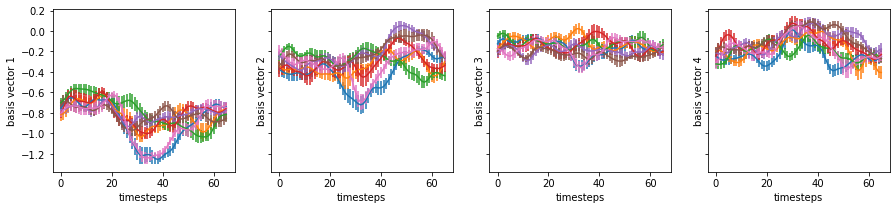

In [8]:
proj = all_projs_stream0

# plotting projected neural trajectories by component and trial type
reach_labels = dict(DownLeft=0, Left=1, UpLeft=2, Up=3, UpRight=4, Right=5, DownRight=6)
proj_by_trial = [[] for _ in range(len(reach_labels))]
t = 0
for i in range(num_trials-1):
    trial_type = reach_labels[trial_types[i]]
    curr_proj = proj[:, t:t+reduced_bins]
    proj_by_trial[trial_type].append(curr_proj)
    t += int(num_steps/bin_size)
    
# averaging over 
mean_pcs_stream0 = np.zeros((len(reach_labels), Qcoll.shape[1], reduced_bins))
std_pcs_stream0 = np.zeros((len(reach_labels), Qcoll.shape[1], reduced_bins))
for i in range(len(reach_labels)):
    proj_by_trial[i] = np.array(proj_by_trial[i])
    mean_pcs_stream0[i, :, :] = np.mean(proj_by_trial[i], axis=0)
    std_pcs_stream0[i, :, :] = np.std(proj_by_trial[i], axis=0) / np.sqrt(proj_by_trial[i].shape[0])
    
    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)

for i in range(4):
    for j in range(7):
        ax[i].errorbar(np.arange(reduced_bins), mean_pcs_stream0[j, i, :], yerr=std_pcs_stream0[j, i, :])
        ax[i].set(xlabel='timesteps', ylabel='basis vector {}'.format(i+1))

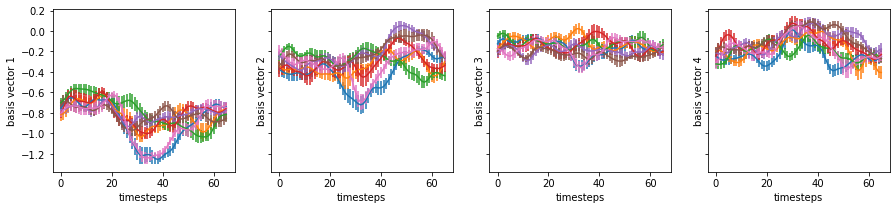

In [9]:
proj = all_projs_streamend

# plotting projected neural trajectories by component and trial type
reach_labels = dict(DownLeft=0, Left=1, UpLeft=2, Up=3, UpRight=4, Right=5, DownRight=6)
proj_by_trial = [[] for _ in range(len(reach_labels))]
t = 0
for i in range(num_trials-1):
    trial_type = reach_labels[trial_types[i]]
    curr_proj = proj[:, t:t+reduced_bins]
    proj_by_trial[trial_type].append(curr_proj)
    t += int(num_steps/bin_size)
    
# averaging over 
mean_pcs_streamend = np.zeros((len(reach_labels), Qcoll.shape[1], reduced_bins))
std_pcs_streamend = np.zeros((len(reach_labels), Qcoll.shape[1], reduced_bins))
for i in range(len(reach_labels)):
    proj_by_trial[i] = np.array(proj_by_trial[i])
    mean_pcs_streamend[i, :, :] = np.mean(proj_by_trial[i], axis=0)
    std_pcs_streamend[i, :, :] = np.std(proj_by_trial[i], axis=0) / np.sqrt(proj_by_trial[i].shape[0])
    
    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)

for i in range(4):
    for j in range(7):
        ax[i].errorbar(np.arange(reduced_bins), mean_pcs_streamend[j, i, :], yerr=std_pcs_streamend[j, i, :])
        ax[i].set(xlabel='timesteps', ylabel='basis vector {}'.format(i+1))

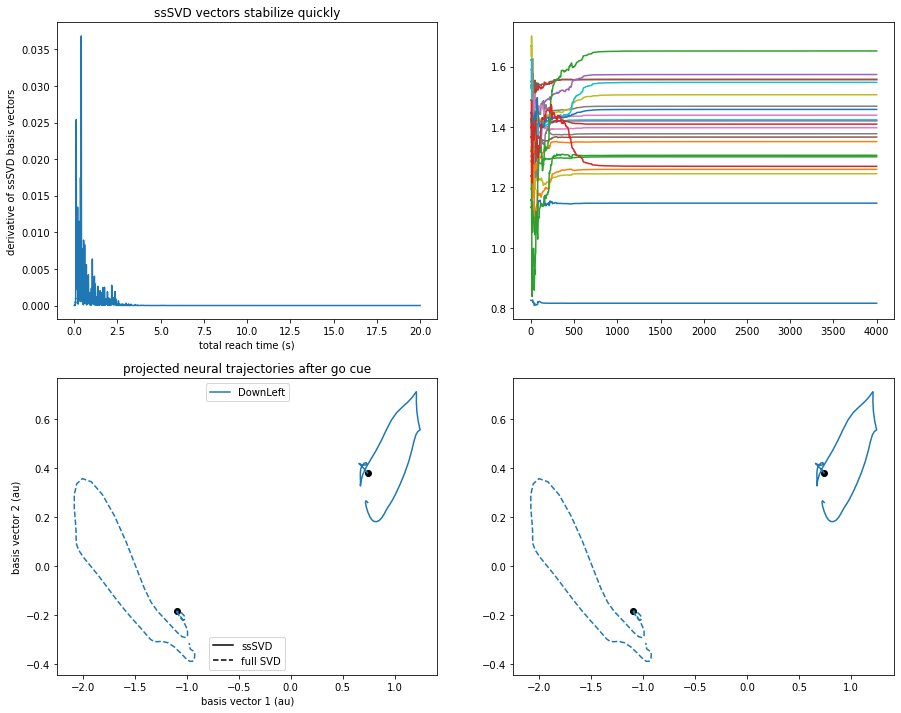

In [10]:
# plotting projected neural trajectory on manifold defined by first two basis vectors

fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(2, 2, 1)

for i in range(1):
    Qvecs = Qcoll[:, i, :]
    Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
    Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
    xrange = (np.arange(Qcoll.shape[2]-1) * 1 * 5) / 1000
    ax1.plot(xrange[:4000], Qvecs_dists[:4000])
    ax1.set(ylabel='derivative of ssSVD basis vectors', xlabel='total reach time (s)',
             title='ssSVD vectors stabilize quickly')
    
ax2 = fig.add_subplot(2, 2, 2)
dists = np.zeros((Qtcoll.shape[1], Qtcoll.shape[2]))
for i in range(Qtcoll.shape[2]):
    Q = Qcoll[:, :, i]
#     Qu = QcollU[:, :, i]
#     dist1 = np.linalg.norm(Q + u, axis=0)
#     dist2 = np.linalg.norm(Q - u, axis=0)
#     dists[:, i] = np.min(np.array([dist1, dist2]), axis=0)
    dists[:, i] = np.linalg.norm(Q - u, axis=0)
ax2.plot(dists[:, :4000].T)    

    
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4, sharex=ax3, sharey=ax3)

labels = ['DownLeft']
for i in range(len(labels)):
    x = -mean_pcs_stream0[i, 0, :]
    y = -mean_pcs_stream0[i, 1, :]
    x = gaussian_filter1d(x, sigma=1)
    y = gaussian_filter1d(y, sigma=1)
    ax3.plot(x, y, color='C{}'.format(i), label=labels[i])
    ax3.scatter(x[0], y[0], c='k')
    
    x = -mean_pcs_streamend[i, 0, :]
    y = -mean_pcs_streamend[i, 1, :]
    x = gaussian_filter1d(x, sigma=1)
    y = gaussian_filter1d(y, sigma=1)
    ax4.plot(x, y, color='C{}'.format(i), label=labels[i])
    ax4.scatter(x[0], y[0], c='k')
    
    
    x = mean_pcs[i, 0, :]
    y = mean_pcs[i, 1, :]
    
    x = gaussian_filter1d(x, sigma=1)
    y = gaussian_filter1d(y, sigma=1)
    for curr_ax in [ax3, ax4]:
        curr_ax.plot(x, y, color='C{}'.format(i), ls='--')
        curr_ax.scatter(x[0], y[0], c='k')
    
ax3.set(title='projected neural trajectories after go cue', 
      xlabel='basis vector 1 (au)', ylabel='basis vector 2 (au)')
legend1 = ax3.legend(loc='upper center')
legend = ax3.add_artist(legend1)

custom_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], color='k', ls='--')]
ax3.legend(custom_lines, ['ssSVD', 'full SVD'], loc='lower center')

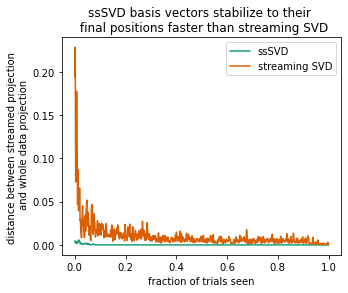

In [11]:
proj = Qcoll[:, :, -1].T.dot(spikes)

dists = np.zeros((all_projs_stream.shape[1]))
for i in range(min(all_projs_stream.shape[1], proj.shape[1])):
    e = all_projs_stream[:1, i]
    r = proj[:1, i]
#     dists[i] = np.min([np.linalg.norm(e - r) / np.linalg.norm(r), np.linalg.norm(e + r) / np.linalg.norm(r)])
#     if dists[i] > 250:
#         print(i, np.linalg.norm(e - r), np.linalg.norm(r))
    dists[i] = np.min([np.linalg.norm(e - r), np.linalg.norm(e + r)])
#     dists[i] = get_dist(e, r, lamb)
fig4, ax4 = plt.subplots(1, 1, figsize=(5, 4))
xrange = np.arange(dists.shape[0]) / dists.shape[0]
ax4.plot(xrange, gaussian_filter1d(dists, sigma=5), label='ssSVD', c=cmap(0))
# for i in np.array([0, 50, 200, 600]) * 15 / 1000:
#     ax4.axvline(i, c='k', alpha=.75, ls='--')
ax4.set(title='ssSVD basis vectors stabilize to their \n final positions faster than streaming SVD', 
        xlabel='fraction of trials seen', 
        ylabel='distance between streamed projection \n and whole data projection')

proj = u.T.dot(spikes)
dists = np.zeros((all_projs_stream_true.shape[1]))
for i in range(min(all_projs_stream_true.shape[1], proj.shape[1])):
    e = all_projs_stream_true[:1, i]
    r = proj[:1, i]
#     dists[i] = np.min([np.linalg.norm(e - r) / np.linalg.norm(r), np.linalg.norm(e + r) / np.linalg.norm(r)])
#     if dists[i] > 250:
#         print(i, np.linalg.norm(e - r), np.linalg.norm(r))
    dists[i] = np.min([np.linalg.norm(e - r), np.linalg.norm(e + r)])
xrange = np.arange(dists.shape[0]) / dists.shape[0]

ax4.plot(xrange, gaussian_filter1d(dists, sigma=5), label='streaming SVD', c=cmap(1))
ax4.legend()

# plt.savefig('figures/cosyne2021/fig3g.svg', bbox_inches='tight')

No handles with labels found to put in legend.


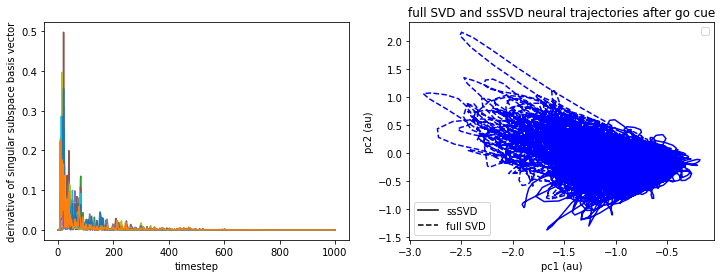

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(12):
    Qvecs = Qcoll[:, i, :]
    Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
    Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
    ax[0].plot(Qvecs_dists[:1000])
    ax[0].set(ylabel='derivative of singular subspace basis vector', xlabel='timestep')


start, end = 1000, 10050

x = all_projs_stream[0, start:end]
y = all_projs_stream[1, start:end]

ax[1].plot(x, y, c='blue')
ax[1].scatter(x[0], y[0], c='k')
    
    
x = proj[0, start:end]
y = proj[1, start:end]
ax[1].plot(x, y, c='blue', ls='--')
ax[1].scatter(x[0], y[0], c='k')
    
ax[1].set(title='full SVD and ssSVD neural trajectories after go cue', 
      xlabel='pc1 (au)', ylabel='pc2 (au)')
legend1 = ax[1].legend(loc='upper right')
ax = plt.gca().add_artist(legend1)

custom_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], color='k', ls='--')]


plt.legend(custom_lines, ['ssSVD', 'full SVD'], loc='lower left')

Text(0.5, 0.94, 'Projection of a single trial onto ssSVD basis vectors (top) or singular vectors (bottom)')

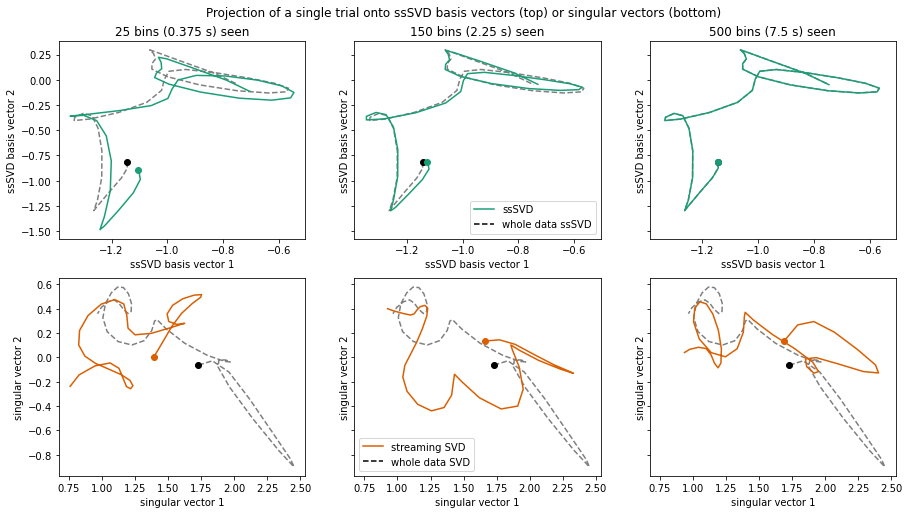

In [20]:
# gs_kw = dict(wspace=0)
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharey='row', sharex='row')

curr_spikes = spikes[:, 1810:1850]

full_proj = Qcoll[:, :, -1].T.dot(curr_spikes)
for i, t in enumerate([0, 125, 475]):
    trial_label = t + l1
    ax[0, i].plot(full_proj[0, :], full_proj[1, :], c='k', alpha=.5, ls='--')
    ax[0, i].scatter(full_proj[0, 0], full_proj[1, 0], c='k')
    
    Q = Qcoll[:, :, t]
    S = Scoll[:, t]
    
    # U is U_inf after ssSVD on whole dataset. QU is rotated Q, and (QU)^T is projection
#     curr_proj = U.T.dot(Q.T).dot(curr_spikes)

    curr_proj = Q.T.dot(curr_spikes)

    ax[0, i].plot(curr_proj[0, :], curr_proj[1, :], color=cmap(0))
    ax[0, i].scatter(curr_proj[0, 0], curr_proj[1, 0], color=cmap(0))
    ax[0, i].set(title='{} bins ({} s) seen'.format(trial_label, (trial_label * 15 / 1000)), 
              xlabel='ssSVD basis vector 1', ylabel='ssSVD basis vector 2')
    


full_proj = Qtcoll[:, :, -1].T.dot(curr_spikes)
for i, t in enumerate([0, 125, 475]):
    trial_label = t + l1
    ax[1, i].plot(full_proj[0, :], full_proj[1, :], c='k', alpha=.5, ls='--')
    ax[1, i].scatter(full_proj[0, 0], full_proj[1, 0], c='k')
    
    Q = Qtcoll[:, :, t]
    S = Scoll[:, t]
    
    # rotating Q to be more aligned with whole svd u
#     T = l2proc_min(Q, u)
#     Q = Q.T.dot(T)
     
    # U is U_inf after ssSVD on whole dataset. QU is rotated Q, and (QU)^T is projection
#     curr_proj = U.T.dot(Q.T).dot(curr_spikes)

    curr_proj = Q.T.dot(curr_spikes)

    ax[1, i].plot(curr_proj[0, :], curr_proj[1, :], color=cmap(1))
    ax[1, i].scatter(curr_proj[0, 0], curr_proj[1, 0], color=cmap(1))
    ax[1, i].set(xlabel='singular vector 1', ylabel='singular vector 2')
    
custom_lines = [Line2D([0], [0], color=cmap(0)),
                Line2D([0], [0], color='k', ls='--')]
ax[0, 1].legend(custom_lines, ['ssSVD', 'whole data ssSVD'], loc='lower right')

custom_lines = [Line2D([0], [0], color=cmap(1)),
                Line2D([0], [0], color='k', ls='--')]
ax[1, 1].legend(custom_lines, ['streaming SVD', 'whole data SVD'], loc='lower left')

fig.suptitle('Projection of a single trial onto ssSVD basis vectors (top) or singular vectors (bottom)', y=.94)


# plt.savefig('figures/cosyne2021/fig3.svg', bbox_inches='tight')